In [4]:
from IPython.core.debugger import set_trace
import unittest
tc = unittest.TestCase('__init__')

import numpy as np
from numpy.linalg import inv

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use = "default"
# mathjax docs: https://math.meta.stackexchange.com/questions/5020/mathjax-basic-tutorial-and-quick-reference

In [5]:
def p(*args):
    for arg in args:
        print(arg)
        print(" ")

# The Problem

Given $A \in \mathbb{R}^{mxn} \text{ and } b \in \mathbb{R}^n$ in the equation:

$Ax = b$
  
We want to solve for $x$

In [6]:
def ex_1():
    return (np.array([
        [4, -1, 2 ,-1],
        [2, 6, 3, -3],
        [1, 1, 5, 0],
        [1, -1, 4, 7]
    ], dtype=np.float64), 
    np.array([[-8, -20, -2, 4]], dtype=np.float64).T,
    np.array([[2, 2, 3, -7]], dtype=np.float64).T)


def ex_2():
    # slide 115
    return (
        np.array([
            [.2, .1, 1, 1, 0],
            [.1, 4, -1, 1, -1],
            [1, -1, 60, 0, -1],
            [1, 1, 0 , 8, 4],
            [0, -1, -2, 4, 700]    
        ]),
        np.array([1,2,3,4,5], dtype=np.float64).T,
        np.array([7.859713071, 0.4229264082, -.07359223906, -.5406430164, .01062616286], dtype=np.float64).T
    )

def ex_3():
    return (
        np.array([
            [4., 3., 0.],
            [3., 4., -1.],
            [0., -1., 4.]
        ]),
        np.array([24., 30., -24.]),
        np.array([3, 4, -5])
    )

def ex_4():
    return (
        np.array([
            [3.3330, 15920, -10.333],
            [2.2220, 16.710, 9.6120],
            [1.5611, 5.1791, 1.6852]
        ]),
        np.array([15913, 28.544, 8.4254]),
        np.array([1, 1, 1])
    )

def ex(number):
    if number == 1:
        return ex_1()
    elif number == 2:
        return ex_2()
    elif number == 3:
        return ex_3()
    elif number == 4:
        return ex_4()

# Gausse Elimination

In [10]:
def swap_rows(m, row_index_1, row_index_2):
    cpy = m.copy()
    cpy[[row_index_1, row_index_2]] = cpy[[row_index_2, row_index_1]]
    return cpy

def swap_rows_if_zero(m, b, pivot_row, pivot_col):
    if m[pivot_row, pivot_col] != 0:
        return m, b
    
    nonzero_indices = np.where(m[pivot_row:, pivot_col] != 0)
    if nonzero_indices[0].size == 0:
        return -1, -1
    m = swap_rows(m, pivot_row, nonzero_indices[0][0] + pivot_row)
    b = swap_rows(b, pivot_row, nonzero_indices[0][0] + pivot_row)
    return m, b

def swap_rows_pivot(m, b, pivot_row, pivot_col): 
    col = m[pivot_row:, pivot_col]
    max_indices = np.where(col == max(col))
    max_i = max_indices[0][0]
    if col[max_i] == 0:
        return -1, -1
    m = swap_rows(m, pivot_row, max_i + pivot_row)
    b = swap_rows(b, pivot_row, max_i + pivot_row)
    
    return m, b

def scale_matrix(m, b):
    rows = m.shape[0]
    for i in range(rows):
        row = np.array(m[i])
        m[i] = row/max(row)
        b[i] = b[i]/max(row)
    return m, b

In [11]:
def forward_elimination(A, b, partial_pivoting=True, scaled=True):
    rows, columns = A.shape
    if scaled:
        A, b = scale_matrix(A, b)
        
    for j in range(columns): 
        if partial_pivoting:
            A, b = swap_rows_pivot(A, b, j, j)
        else:
            A, b = swap_rows_if_zero(A, b, j, j)
            
        if type(A) is int:
            return "System does not have unique solution", False
        a_jj = A[j, j]
        for i in range(1 + j, rows):
            a_ij = A[i, j]
            A[i] = A[i] - (A[j]*a_ij/a_jj) 
            b[i] = b[i] - (b[j]*a_ij/a_jj)
            
    return A, b

In [12]:
# A -> n x m matrix, b -> 1 x m matrix
def backward_substitution(A, b):
    x = []
    rows, columns = A.shape
    A = A[::-1, ::-1]
    b = b[::-1]
    for i in range(rows):
        x.append((b[i] - sum(A[i, :i]))/A[i,i])
        A[:,i] = A[:, i]*x[i]
        
        
    return x[::-1]


In [13]:
def gauss(A, b, partial_pivoting=True, scaled=True):
    A, b = forward_elimination(A, b, partial_pivoting, scaled)
    if type(A) is str:
        print(A)
        return [0]
    return backward_substitution(A, b)

No Pivoting

In [14]:
A, b, x = ex_4()

p_x = gauss(A, b, partial_pivoting=False, scaled=False)
p(p_x, x)

[1.0000000000001614, 1.0, 0.9999999999999687]
 
[1 1 1]
 


Partial Pivoting

In [15]:
A, b, x = ex_4()
p_x = gauss(A, b, scaled=False)

p(p_x, x)

[1.0000000000001614, 1.0, 1.0000000000000264]
 
[1 1 1]
 


Scaled Partial Pivoting

In [16]:
A, b, x = ex_3()
p_x = gauss(A, b)

p(p_x, x)

[2.999999999999999, 4.000000000000001, -4.999999999999999]
 
[ 3  4 -5]
 


# Jacobi Iterative Method

In [17]:
def jacobi_iterative(A, b, num_iterations = -1):
    D = np.diagflat(np.diag(A))
    R = A - D
    L = np.tril(R)
    U = np.triu(R)
    inverse_D = inv(D)
    
    converg_thresh = .001
    error = np.inf
    prev_x = np.zeros(b.shape)
    iterations = [prev_x]
    i = 0
    
    while i < num_iterations if num_iterations > 0 else error > converg_thresh:
        x = inverse_D @ (b - (R @ prev_x))
        iterations.append(x)
        error = np.linalg.norm(x - prev_x) / np.linalg.norm(x)
        prev_x = x
        i += 1
    
    return x, iterations

In [227]:
A, b, x = ex(3)
print(A)
p("Estimation:", jacobi_iterative(A,b)[0], "x:", x)

[[ 4.  3.  0.]
 [ 3.  4. -1.]
 [ 0. -1.  4.]]
Estimation:
 
[ 3.0016263   4.00189735 -5.0005421 ]
 
x:
 
[ 3  4 -5]
 


In [228]:
iters = []
for i in range(1, 5):
    A, b, x = ex(i)
    e_x, ite = jacobi_iterative(A, b)
    p("Example {} ({} iterations)".format(i, len(ite)), np.linalg.norm(x - ite, axis=1))

Example 1 (11 iterations)
 
[[ 8.1240384 ]
 [10.64570219]
 [10.04957891]
 [10.06449904]
 [10.15284989]
 [10.12694232]
 [10.14361475]
 [10.14400361]
 [10.1451485 ]
 [10.14607355]
 [10.14622943]]
 
Example 2 (52 iterations)
 
[7.88997972e+00 3.04665788e+00 5.87247880e+00 2.05913853e+00
 4.29186440e+00 1.38021813e+00 3.14011304e+00 9.17655829e-01
 2.30102584e+00 6.04615448e-01 1.68882905e+00 3.94501787e-01
 1.24147335e+00 2.55011341e-01 9.14044441e-01 1.63841751e-01
 6.73992487e-01 1.05657696e-01 4.97698399e-01 6.98908582e-02
 3.68000656e-01 4.90485066e-02 2.72412385e-01 3.74832089e-02
 2.01834787e-01 3.09463400e-02 1.49627798e-01 2.67185436e-02
 1.10938040e-01 2.34438237e-02 8.22123012e-02 2.05946992e-02
 6.08448732e-02 1.80164710e-02 4.49216170e-02 1.56857803e-02
 3.30339692e-02 1.36104229e-02 2.41436021e-02 1.17951634e-02
 1.74838202e-02 1.02338245e-02 1.24876591e-02 8.91043736e-03
 8.73549092e-03 7.80267470e-03 5.91710247e-03 6.88515998e-03
 3.80525663e-03 6.13197520e-03 2.24167405e-0

/usr/local/Cellar/python3/3.5.0/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/Cellar/python3/3.5.0/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/linalg/linalg.py:2286: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real


# Gauss-Seidel

In [20]:
def gauss_seidel(A, b, num_iterations = -1):
    L = np.tril(A)
    U = A - L
    x0 = np.random.random(b.shape)
    inv_L = inv(L) 
    
    converg_thresh = .001
    error = np.inf
    prev_x = np.zeros(b.shape)
    iterations = [prev_x]
    i = 0
    while i < num_iterations if num_iterations > 0 else error > converg_thresh:
        x = inv_L @ (b - (U @ prev_x))
        iterations.append(x)
        error = np.linalg.norm(x - prev_x) / np.linalg.norm(x)
        prev_x = x
        i += 1
    
    
    return x, iterations

In [21]:
# slide 85/86
A = np.array([
    [4, 3, 0],
    [3, 4, -1],
    [0, -1, 4]
])
b = np.array([24, 30, -24])
x = np.array([3,4,-5])

p("Estimation:", gauss_seidel(A, b)[0], "x:", x)

Estimation:
 
[ 3.00682121  3.99431566 -5.00142109]
 
x:
 
[ 3  4 -5]
 


In [225]:
iters = []
for i in range(1, 5):
    A, b, x = ex(i)
    e_x, ite = gauss_seidel(A, b)
    p("Example {} ({} iterations)".format(i, len(ite)), np.linalg.norm(x - ite, axis=1))

Example 1 (7 iterations)
 
[[ 8.1240384 ]
 [ 9.76174216]
 [10.10917212]
 [10.13363425]
 [10.14364943]
 [10.14584125]
 [10.14638666]]
 
Example 2 (17 iterations)
 
[7.88997972 2.88416589 2.06947307 1.47120086 1.0455911  0.74284941
 0.52750738 0.37433335 0.26537979 0.1878805  0.13275483 0.09354365
 0.06565255 0.04581352 0.031702   0.02166454 0.01452508]
 
Example 3 (13 iterations)
 
[7.07106781 3.17214439 0.98870575 0.61794109 0.38621318 0.24138324
 0.15086453 0.09429033 0.05893146 0.03683216 0.0230201  0.01438756
 0.00899223]
 
Example 4 (56 iterations)
 
[1.73205081e+000 5.41318206e+003 3.42772853e+006 2.16389762e+009
 1.36602472e+012 8.62343620e+014 5.44379986e+017 3.43656011e+020
 2.16943049e+023 1.36951734e+026 8.64548438e+028 5.45771843e+031
 3.44534662e+034 2.17497724e+037 1.37301889e+040 8.66758894e+042
 5.47167258e+045 3.45415560e+048 2.18053817e+051 1.37652939e+054
 8.68975001e+056 5.48566242e+059 3.46298710e+062 2.18611331e+065
 1.38004886e+068 8.71196774e+070 5.49968802e+073 

/usr/local/Cellar/python3/3.5.0/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/Cellar/python3/3.5.0/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/linalg/linalg.py:2286: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real


# Successive Over-Relaxation

In [163]:
def successive_over_relax(A, b, num_iterations = -1):
    D = np.diagflat(np.diag(A))
    L = np.tril(A, -1)
    U = np.triu(A, 1)
    
    converg_thresh = .001
    
    error = np.inf
    w = 1.2
    i = 0
    prev_x = np.ones(b.shape)
    iterations = [prev_x]
    while i < num_iterations if num_iterations > 0 else error > converg_thresh:
        # https://en.wikipedia.org/wiki/Successive_over-relaxation
        x = inv(D + (w * L)) @ ((w * b) - (((w * U) + ((w-1)*D)) @ prev_x))
        error = np.linalg.norm(x - prev_x) / np.linalg.norm(x)
        prev_x = x
        iterations.append(x)
        i += 1
    
    return x, iterations

In [269]:
A, b, x = ex(2)
e_x, ite = successive_over_relax(A, b)
p("Estimation:", e_x, "x:", x, "Iterations:", len(ite))

Estimation:
 
[ 7.85413921  0.42273772 -0.07369662 -0.54005107  0.01062286]
 
x:
 
[ 7.85971307  0.42292641 -0.07359224 -0.54064302  0.01062616]
 
Iterations:
 
14
 


In [218]:
iters = []
for i in range(1, 5):
    A, b, x = ex(i)
    e_x, ite = successive_over_relax(A, b)
    p("Example {} ({} iterations)".format(i, len(ite)), np.linalg.norm(x - ite, axis=1))

Example 1 (9 iterations)
 
[[ 8.36660027]
 [10.03922194]
 [10.3274795 ]
 [10.11788997]
 [10.15000176]
 [10.14451674]
 [10.14758469]
 [10.14621958]
 [10.14666388]]
 
Example 2 (14 iterations)
 
[7.20372953e+00 1.47204960e+01 5.41349828e+00 3.58194025e+00
 1.84439341e+00 1.03689096e+00 5.64848546e-01 3.10028569e-01
 1.69067344e-01 9.16389642e-02 4.90300759e-02 2.55926018e-02
 1.26999750e-02 5.60935586e-03]
 
Example 3 (8 iterations)
 
[7.00000000e+00 3.39066203e+00 3.68807280e-01 1.34873506e-01
 1.25405034e-02 9.03503676e-03 1.71029620e-03 1.01802830e-03]
 
Example 4 (2 iterations)
 
[0.00000000e+00 4.37524076e-13]
 


# Iterative Refinement  

In [25]:
def iterative_refinement(A, b, method, num_iterations=2):
    x = np.array(method(A,b)) 
    for k in range(num_iterations):
        r = b - A @ x
        print(r)
        y = np.array(method(A, r))
        print(y)
        x = x + y
    
    return x

A, b, x = ex_3()
x_ref = iterative_refinement(A, b, gauss)

p("estimated:", x_ref, "actual", x)

[ 0.0000000e+00  0.0000000e+00 -8.8817842e-16]
[ 4.44089210e-16 -5.92118946e-16 -1.03620816e-15]
[0. 0. 0.]
[0. 0. 0.]
estimated:
 
[ 3.  4. -5.]
 
actual
 
[ 3  4 -5]
 


# Conditioned Conjugate Gradient

In [256]:
def conjugate_gradient(A, b, num_iterations = -1):
    x = np.ones(b.shape)
    iterations = [x]
    prev_r = b - (A @ x)
    v = prev_r
    i = 0
    while i < num_iterations if num_iterations > 0 else not np.allclose(prev_r, np.zeros(prev_r.shape), atol=.001):
        Av = A @ v
        
        t = (prev_r.T @ prev_r) / (v.T @ Av)
        x = x + (t * v)
        iterations.append(x)
        
        r = prev_r - (t * Av)
        s = (r.T @ r) / (prev_r.T @ prev_r)
        v = r + (s * v)
        
        prev_r = r
        
        i += 1
    
    return x, iterations

In [257]:
p("Estimation:", conjugate_gradient(A, b)[0], "x:", x)

Estimation:
 
[ 7.85554809  0.42285861 -0.07368613 -0.54010434  0.01062334]
 
x:
 
[ 7.85971307  0.42292641 -0.07359224 -0.54064302  0.01062616]
 


In [263]:
def cc_gradient(A, b, num_iterations = -1):
    C = np.diagflat(np.diag(A))
    x = np.ones(b.shape)
    r = b - (A @ x)
    iterations = [x]
    prev_w = inv(C) @ r
    v = inv(C.T) @ prev_w
    i = 0
    while i < num_iterations if num_iterations > 0 else not np.allclose(r, np.zeros(r.shape), atol=.001):
        Av = A @ v
        
        t = (prev_w.T @ prev_w) / (v.T @ Av)
        x = x + (t * v)
        iterations.append(x)
        
        r = r - (t * Av)
        
        w = inv(C) @ r
        s = (w.T @ w) / (prev_w.T @ prev_w)
        v = (inv(C.T) @ w) + (s * v)
        
        prev_w = w
        
        i += 1
    
    return x, iterations

In [264]:
A, b, x = ex(2)
e_x, ite = cc_gradient(A, b)
p("Estimation:", e_x, "x:", x, "Iterations:", len(ite))

Estimation:
 
[ 7.86266536  0.42288283 -0.07382331 -0.54099818  0.01062867]
 
x:
 
[ 7.85971307  0.42292641 -0.07359224 -0.54064302  0.01062616]
 
Iterations:
 
21
 


In [265]:
iters = []
for i in range(1, 5):
    A, b, x = ex(i)
    e_x, ite = cc_gradient(A, b, 20)
    p("Example {} ({} iterations)".format(i, len(ite)), np.linalg.norm(x - ite, axis=1))

Example 1 (21 iterations)
 
[[ 8.36660027]
 [ 9.94189001]
 [10.2315165 ]
 [10.21837763]
 [10.16576037]
 [10.13968936]
 [10.13638512]
 [10.14889979]
 [10.15850094]
 [10.15853842]
 [10.15206169]
 [10.14244141]
 [10.13369127]
 [10.13020187]
 [10.13252306]
 [10.13800881]
 [10.14442696]
 [10.1506112 ]
 [10.15572336]
 [10.15897825]
 [10.15993801]]
 
Example 2 (21 iterations)
 
[7.20372953e+00 1.36968401e+01 2.78003687e+01 3.20093999e+01
 9.20607248e+00 1.63834774e+01 1.46872599e-01 7.23742372e-02
 1.00705297e-01 1.48617494e-01 3.03791568e-02 2.44738992e-02
 2.78925411e-02 5.14452224e-03 2.56471767e-03 1.82381210e-03
 2.23143075e-03 2.97325277e-03 3.12180775e-03 2.94862846e-03
 2.98286092e-03]
 
Example 3 (21 iterations)
 
[7.00000000e+00 2.02998221e+00 3.92139025e-01 2.51214793e-15
 2.17558393e-15 2.17558393e-15 2.17558393e-15 2.17558393e-15
 2.17558393e-15 2.17558393e-15 2.17558393e-15 2.17558393e-15
 2.17558393e-15 2.17558393e-15 2.17558393e-15 2.17558393e-15
 2.17558393e-15 2.17558393e-15

In [266]:
def run_test(example_num, generate_plot, methods, iterations=-1):
    if not isinstance(methods, list):
        raise Exception("parameter `methods` must be a list of method declarations.")
        
    A, b, x = ex(example_num)
    errors = []
    max_err_length = -np.inf
    for method in methods:
        if iterations > 0:
            e_x, iter_vals = method(A, b, iterations)
        else:
            e_x, iter_vals = method(A, b)
        error = x - np.array(iter_vals)
        errors_string = "\n".join(["i = {} -> norm(X - estimate) = {}".format(i, str(s)) for i, s in enumerate(np.linalg.norm(error, axis=1).tolist())])
        #p("{} errors for each iteration:\n{}".format(method.__name__, errors_string))
        errors.append(error)

    if generate_plot:
        m_names = []
        plot = plt.figure(figsize=(12, 7))
        
        for i, e in enumerate(errors):
            method_name = " ".join(methods[i].__name__.split("_"))
            y =  np.flip(np.sort(np.linalg.norm(e, axis=1)), 0)
            plt.plot(y, label=method_name)
            m_names.append(method_name)
            
        plt.legend(prop={"size": 13})
        plt.ylabel("norm")
        plt.xlabel("iteration")
        plt.title("Example {}".format(example_num))
        plot.savefig("{}.pdf".format(example_num))
        plt.show()
    
    return errors

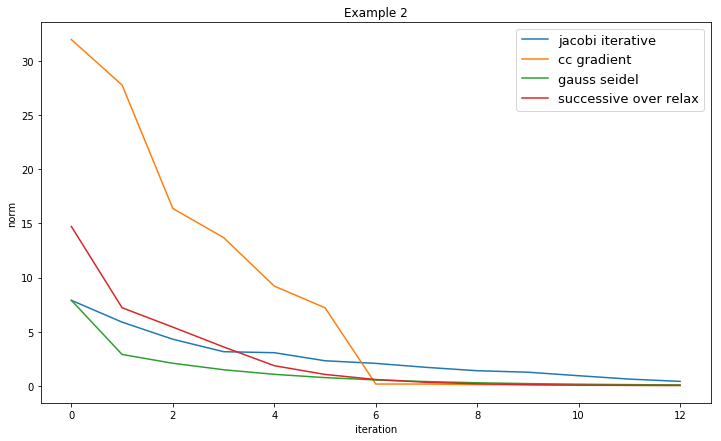

In [268]:
r = run_test(2, True, [jacobi_iterative, cc_gradient, gauss_seidel, successive_over_relax], 12)